In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
import statsmodels.api as sm

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_csv("Sales_Data.csv")
df.head()

,Order Date,Customer ID,Category,Sub-Category,Sales,Quantity,Discount,Marketing,Sales Compensation,Returned
0,2014-05-10,AH-690134,Office Supplies,Storage,13.2000,2,0.60,0.00,1.42,False
1,2012-08-15,AM-10360139,Technology,Phones,4453.0500,7,0.00,1424.85,433.41,False
2,2015-08-29,BV-1124528,Furniture,Tables,2320.6400,5,0.20,0.00,130.77,False
3,2015-05-07,TC-21475130,Technology,Accessories,346.5882,9,0.47,0.00,21.13,False
4,2013-05-10,BW-1111058,Technology,Accessories,334.6800,4,0.00,83.64,63.87,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35903 entries, 0 to 35902
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Order Date          35903 non-null  object 
 1   Customer ID         35903 non-null  object 
 2   Category            35903 non-null  object 
 3   Sub-Category        35903 non-null  object 
 4   Sales               35903 non-null  float64
 5   Quantity            35903 non-null  int64  
 6   Discount            35903 non-null  float64
 7   Marketing           35903 non-null  float64
 8   Sales Compensation  35903 non-null  float64
 9   Returned            35903 non-null  bool   
dtypes: bool(1), float64(4), int64(1), object(4)
memory usage: 2.5+ MB


In [4]:
#converting Order Date column type to datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])

In [5]:
df = df.sort_values("Order Date")

In [6]:
#getting daily total sales
gunluk = df.groupby('Order Date')['Sales'].sum().reset_index()
gunluk

,Order Date,Sales
0,2012-01-01,400.26300
1,2012-01-03,4090.20120
2,2012-01-04,2271.80200
3,2012-01-05,3443.40600
4,2012-01-06,99.59580
...,...,...
1406,2015-12-27,11092.50396
1407,2015-12-28,1409.84400
1408,2015-12-29,18393.50660
1409,2015-12-30,10061.22210


In [7]:
gunluk = gunluk.set_index("Order Date")
gunluk

,Sales
Order Date,
2012-01-01,400.26300
2012-01-03,4090.20120
2012-01-04,2271.80200
2012-01-05,3443.40600
2012-01-06,99.59580
...,...
2015-12-27,11092.50396
2015-12-28,1409.84400
2015-12-29,18393.50660


In [8]:
#monthly average sales
aylik = gunluk['Sales'].resample('MS').mean()

In [9]:
aylik['2015':]

Order Date
2015-01-01     6117.763939
2015-02-01     4612.613730
2015-03-01     6542.290851
2015-04-01     5741.967824
2015-05-01     6317.757301
2015-06-01     9107.138554
2015-07-01     6259.775153
2015-08-01    10981.943646
2015-09-01    11565.657121
2015-10-01     9658.873454
2015-11-01    13056.627455
2015-12-01    10866.864252
Freq: MS, Name: Sales, dtype: float64

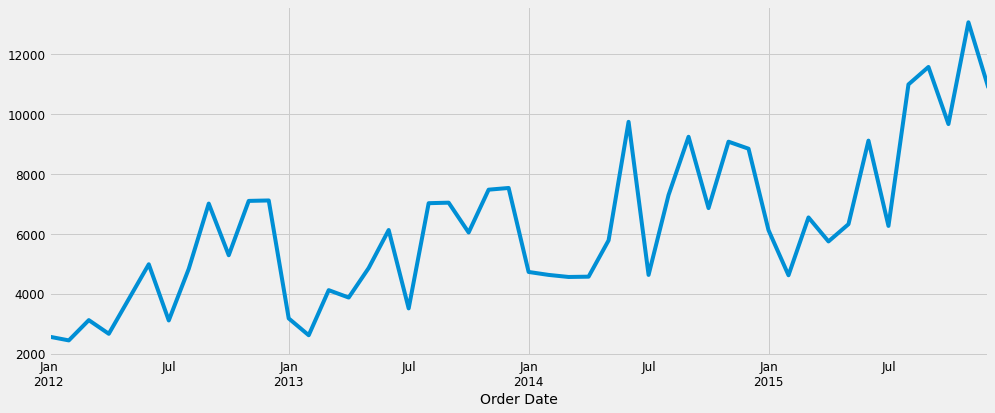

In [10]:
aylik.plot(figsize=(15, 6))
plt.show()

If we visualize the data, we can see that there is seasonality.

We will use time-series decompostion to observe trend, seasonality and residual.

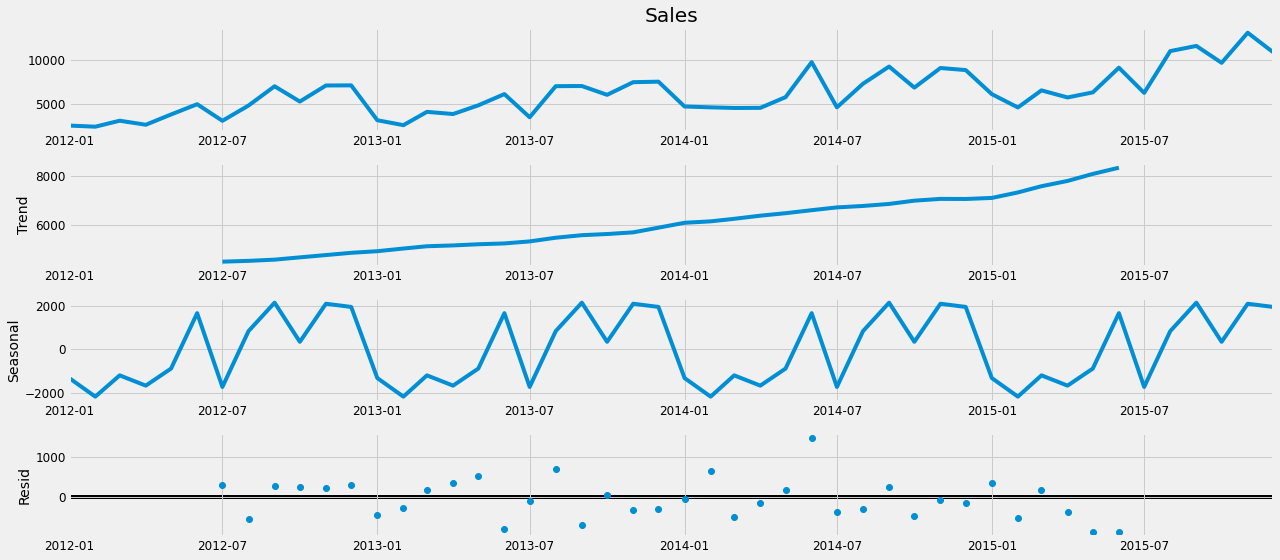

In [11]:
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(aylik, model='additive')
fig = decomposition.plot()
plt.show()

In [12]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(aylik,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
            
results = mod.fit()

print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))       

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:360.0129880482379


In [14]:
mod = sm.tsa.statespace.SARIMAX(aylik,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4468      0.401     -1.113      0.266      -1.234       0.340
ma.L1         -0.2557      0.426     -0.600      0.549      -1.092       0.580
ar.S.L12      -0.9158      0.265     -3.455      0.001      -1.435      -0.396
ma.S.L12       0.1108      0.356      0.311      0.756      -0.588       0.809
sigma2      1.011e+06   3.36e+05      3.008      0.003    3.52e+05    1.67e+06


We will compare our forecast with 2015 sales.

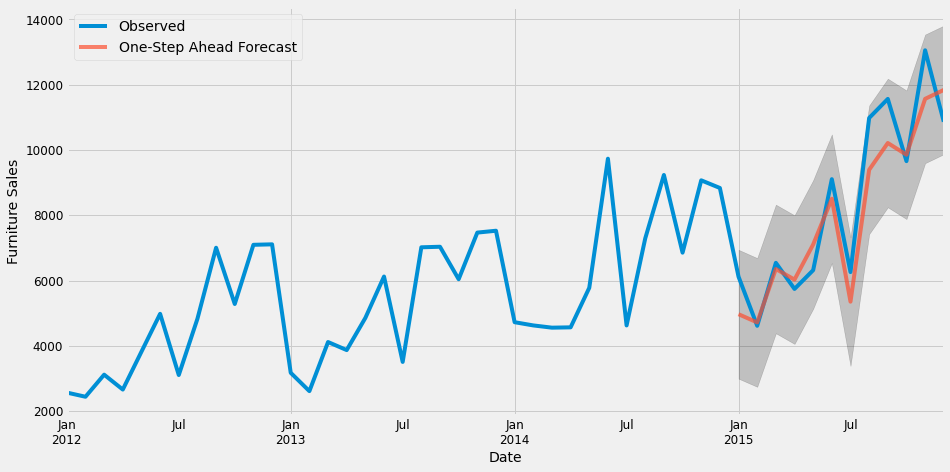

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = aylik['2012':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Our findings are very close to the actual values, also showing the seasonality and trend.

In [16]:
y_forecasted = pred.predicted_mean
y_truth = aylik['2015-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 900721.7


In [17]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 949.06


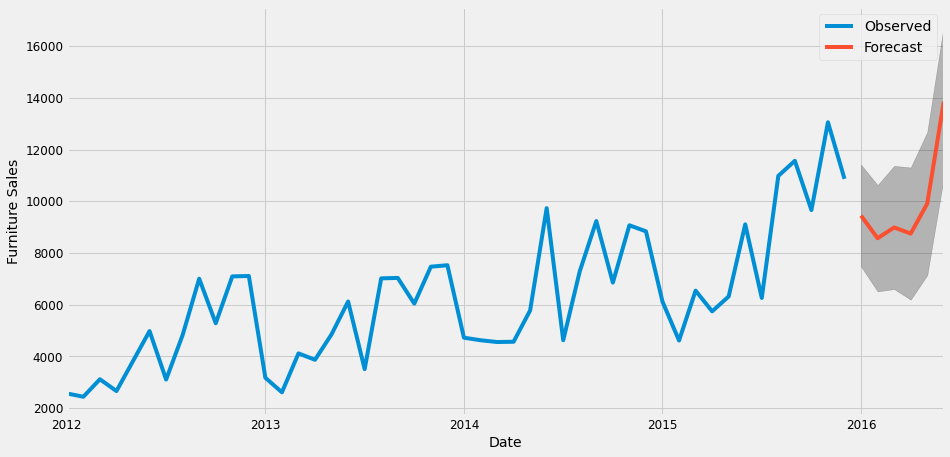

In [18]:
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = aylik.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Confidence intervals for our prediction

In [19]:
pred_ci

,lower Sales,upper Sales
2016-01-01,7473.931422,11415.381098
2016-02-01,6513.981799,10626.021997
2016-03-01,6604.227575,11370.248221
2016-04-01,6192.605978,11307.489725
2016-05-01,7143.804661,12674.416424
2016-06-01,10916.130843,16794.986563
